<a href="https://colab.research.google.com/github/WayTooPeak/Flowise/blob/main/youtube_channel_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search and export Youtube channels

This script searches for channels based on a user query and saves the channel details in an Excel file.

To run it you need to adjust this line:

```
queries = ["amazon marketing", "amazon vendor", "amazon fba"]
```

Afterwards an Excel file is created which can be downloaded.

Note

In [ ]:
# Register an API key
# https://developers.google.com/youtube/registering_an_application?hl=en

# Documentation Youtube API
# https://developers.google.com/resources/api-libraries/documentation/youtube/v3/python/latest/youtube_v3.search.html
# https://developers.google.com/resources/api-libraries/documentation/youtube/v3/python/latest/youtube_v3.channels.html

# Google Account / API quota
# https://console.cloud.google.com/apis/api/youtube.googleapis.com/quotas
# 1,000 requests per day is maximum

In [ ]:
# Install relevant libraries
!pip install pandas openpyxl
!pip install google-api-python-client
!pip install python-slugify
!pip install python-dotenv

In [ ]:
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import json
import time
import pandas as pd
from datetime import datetime
from slugify import slugify
from dotenv import load_dotenv

In [ ]:
# Load variables from .env file
load_dotenv('.env')

# Use variables
api_key = os.getenv('YOUTUBE_API_KEY')

# Alternative: Set it directly
# https://console.cloud.google.com/apis/credentials
# api_key = "xxx"

# Functions

In [ ]:
# Searches channels for a query
def search_youtube(query, type = "channel", max_pages = 10):
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)

    next_page_token = None
    all_results = []
    i = 0

    while True:
        i = i + 1
        print(f"Query: {query} | Type {type} | Page: {i}")
        request = youtube.search().list(
            part="snippet",
            type=type, # channel of video
            q = query, # Set below
            regionCode = regionCode, # Set below
            maxResults=50,
            order="date",
            pageToken=next_page_token
        )
        response = request.execute()
        all_results += response['items']

        if i >= max_pages:
          break

        time.sleep(2) # Avoid rate limits

        if 'nextPageToken' in response:
            next_page_token = response['nextPageToken']
        else:
            break

    return all_results

In [ ]:
# Returns channel details for a channelId
def get_channel_details(channel_id):
    youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=api_key)
    request = youtube.channels().list(
        part=["snippet", "statistics"],
        id = channel_id
    )
    response = request.execute()
    return response['items']

# Main program

In [ ]:
regionCode = "US"

queries = ["amazon marketing", "amazon fba"] # Add queries here!

max_pages = 2 # Defines the number of results per page (50 results per page)

In [ ]:
# Create empty arrays to hold the data
data = []
channel_ids = []

# Iterate over each query
for query in queries:
    channels = search_youtube(query, "channel", max_pages = max_pages) # Get channels
    videos   = search_youtube(query, "video", max_pages = max_pages)   # Get videos

    channel_ids_channels = [item['snippet']['channelId'] for item in channels]
    channel_ids_videos = [item['snippet']['channelId'] for item in videos]

    channel_ids_temp = list(set(channel_ids_channels + channel_ids_videos)) # Remove duplicates

    print(f"Query: {query}: Found {len(channel_ids_channels)} channels and {len(channel_ids_videos)} videos")

    channel_ids.append(channel_ids_temp)

# Flatten list of lists
channel_ids_flat = [item for sublist in channel_ids for item in sublist]

# Remove duplicates
channel_ids_flat = list(set(channel_ids_flat))

print(f"Found {len(channel_ids_flat)} unique channel_ids")

# Get channel details for each channelId
for channel_id in channel_ids_flat:
    channel_details = get_channel_details(channel_id)

    for detail in channel_details:
        data.append({
            'id': detail['id'],
            'description': detail['snippet'].get('description', ''),
            'customUrl': detail['snippet'].get('customUrl', ''),
            'link': 'https://www.youtube.com/c/' + detail['snippet'].get('customUrl', ''),
            'country': detail['snippet'].get('country', ''),
            'viewCount': detail['statistics'].get('viewCount', ''),
            'subscriberCount': detail['statistics'].get('subscriberCount', ''),
            'videoCount': detail['statistics'].get('videoCount', '')
        })

# Convert the list of dicts to a DataFrame
df = pd.DataFrame(data)

# Make columns integers
df = df.astype({"viewCount":"int","subscriberCount":"int","videoCount":"int"})

print(f"Before duplicates: {len(df)}")

# Remove duplicates
df = df.drop_duplicates(subset='id', keep="first")

print(f"Before filter: {len(df)}")

# Filter only channels which have more than 50 subscribers
df = df[df['subscriberCount'] > 50]

# Filter only channels which have more than 5 videos
df = df[df['videoCount'] > 5]

# Filter channels which have "Amazon" in their description
df[df['description'].str.contains("amazon|Amazon|AMAZON")]

# Sort df by subscribers
df = df.sort_values('subscriberCount', ascending=False)

print(f"Final result: {len(df)}")

# Get the current date and time and format it
current_datetime = datetime.now().strftime("%Y-%m-%d-%H-%M")
query_slug = slugify(query)
filename = f"{current_datetime}-{regionCode}-channel_details.xlsx"

# Save the DataFrame to an Excel file with the prefixed filename
df.to_excel(filename, index=False)

df

Query: amazon marketing | Type channel | Page: 1
Query: amazon marketing | Type channel | Page: 2
Query: amazon marketing | Type video | Page: 1
Query: amazon marketing | Type video | Page: 2
Query: amazon marketing: Found 100 channels and 100 videos
Query: amazon fba | Type channel | Page: 1
Query: amazon fba | Type channel | Page: 2
Query: amazon fba | Type video | Page: 1
Query: amazon fba | Type video | Page: 2
Query: amazon fba: Found 100 channels and 100 videos
Found 347 unique channel_ids
Before duplicates: 347
Before filter: 347
Final result: 161


,id,description,customUrl,link,country,viewCount,subscriberCount,videoCount
29,UCyLplL7WIPsy1qdv8MSmDJw,How to get job\nI am Sanjiv Kumar Jindal. I am...,@sanjivkumarjindal-jobs-skills,https://www.youtube.com/c/@sanjivkumarjindal-j...,IN,355686456,5970000,476
10,UCZDCqcWZVNyvTSsoc-chKJg,"Agar Aap bhi Ek YouTuber Banna Chahte h, Basic...",@spreadinggyanofficial,https://www.youtube.com/c/@spreadinggyanofficial,IN,180607674,2450000,279
148,UCxgAuX3XZROujMmGphN_scA,I firmly believe that anyone who learns the sk...,@marktilbury,https://www.youtube.com/c/@marktilbury,GB,208239907,1990000,126
21,UCA7RxVq2pMGYp_-Qo4S2dEw,"नमस्कार दोस्तों , स्वागत है आपका हमारे चैनल टे...",@technicalyogi,https://www.youtube.com/c/@technicalyogi,IN,250230923,1830000,2419
190,UCLoWcRy-ZjA-Erh0p_VDLjQ,Das Y-Kollektiv besteht aus jungen Journalist:...,@ykollektiv,https://www.youtube.com/c/@ykollektiv,DE,342706658,1100000,373
...,...,...,...,...,...,...,...,...
123,UCpqgyDO7KvrSEJV6vDZhBpg,Aprende paso a paso como iniciar un nuevo NEGO...,@academiaamazonfba777,https://www.youtube.com/c/@academiaamazonfba777,,88285,75,60
279,UCZ_5xsWlPrhLz_bfgFWRIOg,Find me at all my other socials @fbadojo,@fbadojo,https://www.youtube.com/c/@fbadojo,,33325,73,61
259,UCYC_ubSgL5k66ffrVQ0iUSg,Online Amazon marketing,@imranahmedani7228,https://www.youtube.com/c/@imranahmedani7228,,34034,70,45
248,UC-nOkbUrfXPCMR_lk4HfxJQ,Cette chaine est là pour vous faire découvrir ...,@nicofba4349,https://www.youtube.com/c/@nicofba4349,FR,36851,69,56


# Download

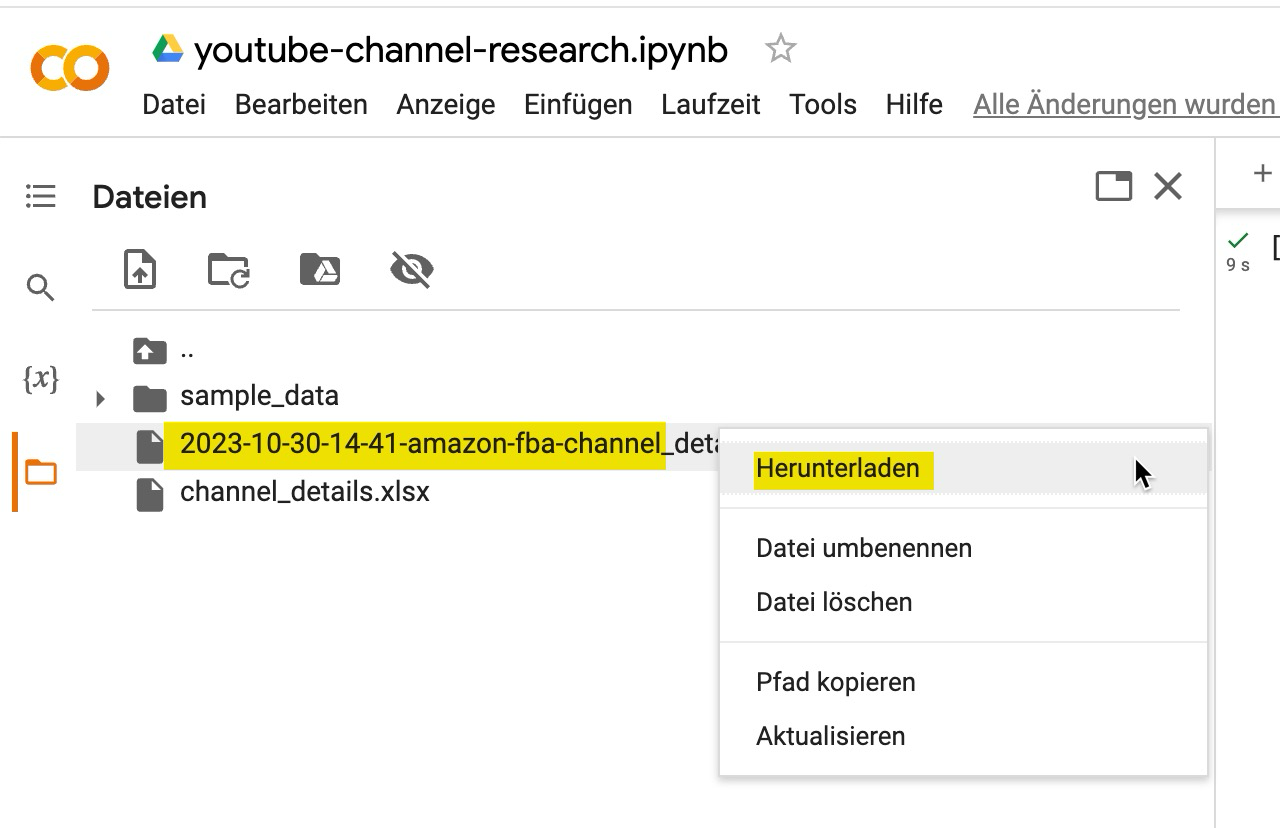

# Playground

## Search for channel

In [ ]:
response = search_youtube("amazon fba", "channel", max_pages = 1)

print(json.dumps(response[:2], indent=2)) # First three elements

Query: amazon fba | Type channel | Page: 1
[
  {
    "kind": "youtube#searchResult",
    "etag": "0XT4xE-Vs4cP8C0F4MXRoyPo9rU",
    "id": {
      "kind": "youtube#channel",
      "channelId": "UCeDRhXuYkLQ9uQjRCRTQO9w"
    },
    "snippet": {
      "publishedAt": "2023-11-05T13:25:02Z",
      "channelId": "UCeDRhXuYkLQ9uQjRCRTQO9w",
      "title": "Vendeur Amazon",
      "description": "Cette cha\u00eene est sp\u00e9cialis\u00e9e dans le business en ligne et plus particuli\u00e8rement dans le business Amazon. Venez nous rejoindre ...",
      "thumbnails": {
        "default": {
          "url": "https://yt3.ggpht.com/3AVjrAeTqKxOASO_2MF8iqM6kv37qNY9ER-ucn8SD20ZIo0q0FZFZu1OMZ4ZTjHLVf1G1atyKg=s88-c-k-c0xffffffff-no-rj-mo"
        },
        "medium": {
          "url": "https://yt3.ggpht.com/3AVjrAeTqKxOASO_2MF8iqM6kv37qNY9ER-ucn8SD20ZIo0q0FZFZu1OMZ4ZTjHLVf1G1atyKg=s240-c-k-c0xffffffff-no-rj-mo"
        },
        "high": {
          "url": "https://yt3.ggpht.com/3AVjrAeTqKxOASO_2MF8iqM6

In [ ]:
response = search_youtube("amazon vendor", "video", 1)
print(json.dumps(response[:2], indent=2)) # First three elements

Query: amazon vendor | Type video | Page: 1
[
  {
    "kind": "youtube#searchResult",
    "etag": "lhK6eyAEZHYYsJh8KKzwtdOnpbo",
    "id": {
      "kind": "youtube#video",
      "videoId": "_cqCuFljNug"
    },
    "snippet": {
      "publishedAt": "2023-11-05T20:55:19Z",
      "channelId": "UC0-5Jkk09Dp6x6LDhECPtRg",
      "title": "FREE Amazon Prime + Prime Video | Crack-Software WORKING 2023  SZIKEz",
      "description": "Link: telegra.ph/New-version-11-01 P\u0410SS: 2227 Cml5sTi Tags: amazon, amazon canada, jeff bezos, alexa, amazon smile, kindle, ...",
      "thumbnails": {
        "default": {
          "url": "https://i.ytimg.com/vi/_cqCuFljNug/default.jpg",
          "width": 120,
          "height": 90
        },
        "medium": {
          "url": "https://i.ytimg.com/vi/_cqCuFljNug/mqdefault.jpg",
          "width": 320,
          "height": 180
        },
        "high": {
          "url": "https://i.ytimg.com/vi/_cqCuFljNug/hqdefault.jpg",
          "width": 480,
         

In [ ]:
response = get_channel_details('UCxkIzPnPzWLz4IeuxIROflg')
print(json.dumps(response, indent=2))

[
  {
    "kind": "youtube#channel",
    "etag": "tF64tb7FLNTj7rU_3khtRJfqyn4",
    "id": "UCxkIzPnPzWLz4IeuxIROflg",
    "snippet": {
      "title": "Travis Marziani",
      "description": "This channel will teach you how to leverage Amazon FBA, Shopify, Adwords, Facebook ads and other secret internet marketing strategies to create a business you love, create freedom and enjoy the journey.  \n\nI have done well over 7 figures of sales on and off Amazon, and want to share what I wish I would have known when I first started, including how to create a passion product.  \n\nI was  depressed and stuck in the corporate world , when I quit that to start  an online dance clothing business with my mom.  After years of growing the revenue but struggling to make enough profit to support my self I had to move back in with my parents.  It was at this point I realized I want to create a business I was passionate about, and I took all the lessons learned and created my first passion product which we